# YOLO V1 face detector

## download file
roboflow could download our own uploaded dataset and it is very convinient and fast to download data from roboflow.

In [111]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AigV8d7mGnZ9MMZyXOX0")
project = rf.workspace().project("face-maks-yolo-v1")
dataset = project.version(2).download("voc")

ERROR: Operation cancelled by user
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to face-maks-yolo-v1-2 in voc:: 100%|██████████| 5393/5393 [00:00<00:00, 7704.05it/s]


file classification(image + annotation)

In [112]:
import os, shutil
def file_move(is_train = True):
  file_type = "train/"
  if not is_train:
    file_type = "valid/"
  main_dir = "/content/face-maks-yolo-v1-2"
  file_path = os.path.join(main_dir, file_type)
  pathDir = os.listdir(file_path)
  target_images = os.path.join(file_path,"images/")
  target_annotations = os.path.join(file_path,"annotations/")
  if not os.path.exists(target_images):
    os.mkdir(target_images)
  if not os.path.exists(target_annotations):
    os.mkdir(target_annotations)
  for name in pathDir:
    if name[-1] == 'g':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_images)
    elif name[-1] == 'l':
      old_pos = os.path.join(file_path, name)
      shutil.move(old_pos, target_annotations)

file_move(is_train = False)
file_move()

## data preprocessing



In [15]:
import xml.etree.ElementTree as ET
import os
import cv2

DATA_PATH = "/content/face-maks-yolo-v1-2/train/"
NUM_BBOX = 2
NUM_CLASS = 0

def convert_annotation(annotation_name):
  in_file = open(DATA_PATH + 'annotations/%s'%(annotation_name))
  image_id = annotation_name[0: len(annotation_name)-4]
  label_path = os.path.join(DATA_PATH, 'labels/')
  if not os.path.exists(label_path):
    os.mkdir(label_path)
  out_file = open(label_path+'%s.txt'%(image_id),'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)
  for obj in root.iter('object'):
    # cls = obj.find('name').text
    # if cls not in CLASSEs:
    #   continue
    # cls_id = CLASSES.index(cls)
    xmlbox = obj.find('bndbox')
    location = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
             float(xmlbox.find('ymax').text))
    bounding_box = convert((w,h),location)
    out_file.write(" ".join([str(a) for a in bounding_box])+"\n")

def xml2txt():
  dir = os.listdir(DATA_PATH+'annotations')
  for file in dir:
    convert_annotation(file)

def convert(size, box):
    # dw = 1. / size[0] #for normalization
    # dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    # x = x * dw
    # w = w * dw
    # y = y * dh
    # h = h * dh
    return (x, y, w, h)

In [ ]:
xml2txt()

## face dataset
To prepare the dataset class for pytorch data loader

In [6]:
from torch.utils.data import Dataset
import torchvision
import numpy as np

class mask_data_set(Dataset):
    def __init__(self, is_train=True):
      self.filenames = []
      self.root_path = "/content/face-maks-yolo-v1-2/train"
      if is_train:
        f = os.listdir("/content/face-maks-yolo-v1-2/train/images")
        self.filenames = [x[0:len(x)-4] for x in f]
      else:
        f = os.listdir("/content/face-maks-yolo-v1-2/valid/images")
        self.filenames = [x[0:len(x)-4] for x in f]
        self.root_path = "/content/face-maks-yolo-v1-2/valid"
      self.img_path = os.path.join(self.root_path, "images/")
      self.label_path = os.path.join(self.root_path, "labels/")

    def __len__(self):
      return len(self.filenames)
  
    def __getitem__(self, item):
      img = cv2.imread(self.img_path+self.filenames[item]+'.jpg')
      img = cv2.resize(img,(448,448))
      f = open(self.label_path+self.filenames[item]+'.txt')
      bbox = f.read().split('\n')
      bbox = [x.split() for x in bbox]
      bbox = bbox[0:len(bbox)-1]
      labels = self.bbox2label(bbox)
      img = torchvision.transforms.ToTensor()(img)
      labels = torchvision.transforms.ToTensor()(labels)
      return img, labels


    def bbox2label(self, bbox):
      cell_size = 7
      img_size = 448
      output = np.zeros((cell_size,cell_size,5+NUM_CLASS))
      for box in bbox:
        x = float(box[0])
        y = float(box[1])
        w = float(box[2])
        h = float(box[3])
        x_cell = int(x * cell_size / img_size)
        y_cell = int(y * cell_size / img_size)
        result = [x,y,w,h,1]
        output[x_cell, y_cell] = result
      return output

## LOSS function
the loss function of YOLO V1

In [2]:
import math
import torch
import torch.nn as nn

class yolov1_Loss(nn.Module):
  def __init__(self):
        super(yolov1_Loss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

  def calculate_IOU(self, box1,box2):
      left_x1 = box1[0]-box1[3]/2
      left_y1 = box1[1]+box1[2]/2
      right_x1 = box1[0]+box1[3]/2
      right_y1 = box1[1]-box1[2]/2
      rec1 = [left_x1, left_y1, right_x1, right_y1]
      left_x2 = box2[0]-box2[3]/2
      left_y2 = box2[1]+box2[2]/2
      right_x2 = box2[0]+box2[3]/2
      right_y2 = box2[1]-box2[2]/2
      rec2 = [left_x2, left_y2, right_x2, right_y2]
      left_max  = max(rec1[0],rec2[0])
      top_max = max(rec1[1],rec2[1])
      right_min = min(rec1[2],rec2[2])
      bottom_min = min(rec1[3],rec2[3])
      #if box1 and box2 are intersecting each other
      if (left_max < right_min or bottom_min > top_max):
        rect1_area = (rec1[2]-rec1[0])*(rec1[3]-rec1[1])
        rect2_area = (rec2[2]-rec2[0])*(rec2[3]-rec2[1])
        area_cross = (bottom_min - top_max)*(right_min - left_max)
        return area_cross/(rect1_area+rect2_area-area_cross)
      else:
        return 0


    # define the 5 components of the loss function(tested!!!!!!!!!)
  def center_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(box[0:2]), torch.flatten(gt_box[0:2]))
      return loss

  def wh_loss(self, box, gt_box):
      # box size: [cx, cy, w, h, confidence]
      loss = 5 * self.mse(torch.flatten(torch.sqrt(abs(box[2:4]))), torch.flatten(torch.sqrt(gt_box[2:4])))
      return loss

  def object_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(100).float().cuda())

  def noobject_confidence_loss(self, box, iou):
      return self.mse(torch.flatten(box[4]),torch.tensor(0).float().cuda())

  def classification_loss(self, pred_class, gt_box):
      loss = self.mse(torch.flatten(pred_class), torch.flatten(gt_box[5:]))
      return loss

  # the whole process
  def forward(self, pred, labels):
        # five components of the loss function
        bnd_center_loss = 0  # bounding box center loss
        bnd_wh_loss = 0  # bounding box width and height loss
        obj_confident_loss = 0  # confidence loss for bounding box with object witin
        noobj_confident_loss = 0  # confidence loss for bounding box without object within
        # classification_loss = 0  # classification loss
        n_batch = labels.shape[0]
        for i in range(n_batch):
          for m in range(7):
            for n in range(7):
              #only iterate column with confidence value =1
              if labels[i, 4, m, n] == 1:
                # first we need to select the bounding box which has
                # a higher IOU with the ground truth bounding box
                current_pred = pred[i,:, m, n]
                current_label = labels[i,:, m, n]
                box1 = current_pred[0:5]
                pred_class = current_pred[10:]
                box2 = current_pred[5:10]
                iou1 = self.calculate_IOU(box1, current_label)
                iou2 = self.calculate_IOU(box2, current_label)
                # print('box1:  {}\n, box2: {}'.format(iou1,iou2))
                #if box1 has a higher iou, then box1 would be responsible for this task.
                if iou1 >= iou2:
                  bnd_center_loss += self.center_loss(box1, current_label)                     
                  bnd_wh_loss += self.wh_loss(box1, current_label)
                  obj_confident_loss += self.object_confidence_loss(box1, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box2, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
                # otherwise, box2 would take this responsibility!
                else:
                  bnd_center_loss += self.center_loss(box2, current_label)                     
                  bnd_wh_loss += self.wh_loss(box2, current_label)
                  obj_confident_loss += self.object_confidence_loss(box2, iou1)
                  noobj_confident_loss += self.noobject_confidence_loss(box1, iou2)
                  # classification_loss += self.classification_loss(pred_class, current_label)
              else:
                noobj_confident_loss += torch.sum(pred[i,[4,9],m,n]**2)
        print("current_pred:  ", current_pred)
        print("current_label: ", current_label)
        total_loss = bnd_center_loss + bnd_wh_loss + obj_confident_loss + noobj_confident_loss
        return torch.sum(total_loss)/n_batch

## Model
The original yolo v1 model


In [1]:
import torch
import torch.nn as nn

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

target_image_size = 448


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1)).reshape(-1, 10, 7, 7)

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

x = torch.randn((5,3,448,448))
net = Yolov1(split_size=7, num_boxes=2, num_classes=0)
print(net)
y = net(x)
print(y.shape)

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

## training

In [8]:
import torch
from torch.utils.data import DataLoader
import cv2
import os

In [ ]:
epoch = 60
batchsize = 32
dataset = mask_data_set(is_train=True)
train_dataloader = DataLoader(dataset, batchsize, shuffle = True)

In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=0).cuda()
criterion = yolov1_Loss()
training_loss = np.zeros(epoch)
saved_model_path = "/content/saved_models"
if not os.path.exists(saved_model_path):
  os.mkdir("/content/saved_models")
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)
for e in range(epoch):
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.float().cuda()
        labels = labels.float().cuda()
        pred = model(inputs)
        # print(pred.shape, labels.shape)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("----------------------------------------------------------------------------------------------")
        print("Epoch %d/%d| Step %d/%d| Loss: %.2f" % (e+1, epoch, i, len(dataset) // batchsize, loss))
        print("----------------------------------------------------------------------------------------------")
    training_loss[e] = loss
    if (e + 1) % 20 == 0:
      torch.save(model, "./saved_models/YOLOv1_epoch" + str(e + 1) + ".pkl")

## learning curve

Text(0, 0.5, 'error')

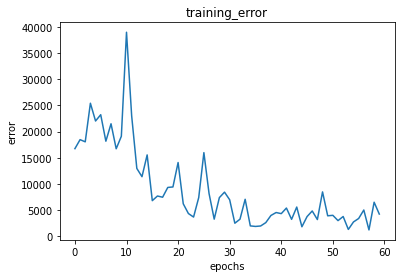

In [ ]:
import matplotlib.pyplot as plt
x = range(0,60)
plt.plot(x, training_loss)
plt.title("training_error")
plt.xlabel("epochs")
plt.ylabel("error")

## evaluation

In [4]:
import torch
from torch.utils.data import DataLoader

In [9]:
batchsize = 1
dataset = mask_data_set(is_train=False)
val_dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [10]:
model = torch.load("/content/saved_models/YOLOv1_epoch60.pkl")

from the evaluation, we can see the loss is obviously higher than training loss, which means it endures overfitting. However, we can see for each bounding box the model predited, the class is correctly predicted and the coordinates predicted are very similar to the ground truth coordinates, which is not bad.

In [11]:
criterion = yolov1_Loss()

In [12]:
loss = np.zeros(dataset.__len__())

In [16]:
for i, (inputs, labels) in enumerate(val_dataloader):
  inputs = inputs.float().cuda()
  labels = labels.float().cuda()
  pred = model(inputs)
  l = criterion(pred, labels)
  loss[i] = l

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


current_pred:   tensor([ 257.1469,  159.3435,  137.5422, -160.5809,   -8.8897,  271.2392,
         146.0524,  149.8329,  168.5262,    1.0304], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([259., 187., 224., 238.,   1.], device='cuda:0')
current_pred:   tensor([ 207.0381,  126.8183, -231.9464,  178.6880,    0.4827,  243.4160,
         115.4359,  102.1248,  127.1843,   92.2321], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([245.0000, 121.5000, 118.0000, 143.0000,   1.0000], device='cuda:0')
current_pred:   tensor([ 241.7699,  177.2225,  154.2772,  198.7217,  106.0263,  235.0675,
         177.7598, -196.9166,  233.9194,   -0.5288], device='cuda:0',
       grad_fn=<SelectBackward0>)
current_label:  tensor([247., 164., 130., 172.,   1.], device='cuda:0')
current_pred:   tensor([ 315.4814,  276.6993,   93.5967,  129.8488,   86.3422,  258.6023,
         278.9601, -128.9982,  168.3096,    3.6962], device='cuda:0',
       grad_fn=<Select

In [17]:
loss.sum()/dataset.__len__()

13595.505199517143

## Prediction

In [ ]:
import cv2
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  return img

def max_index(t):
  for index, i in enumerate(t):
    if i == max(t):
      return index
  return -1

def classification(pred):
  mask = []
  face = []
  incorrect = []
  for i in range(7):
    for j in range(7):
      onehot = pred[i,j,10:13]
      pred_class = max_index(onehot)
      if pred_class == 0:
        mask.append(pred[i,j])
      elif pred_class == 1:
        face.append(pred[i,j])
      else:
        incorrect.append(pred[i,j])
  mask = move_the_bad(mask)
  face = move_the_bad(face)
  incorrect = move_the_bad(incorrect)
  return mask, face, incorrect

def move_the_bad(boxes):
  for index, box in enumerate(boxes):
    if box[4]>=box[9]:
      box = torch.cat((box[0:5],box[10:13]),dim=0)
    else:
      box = torch.cat((box[5:10],box[10:13]),dim=0)
    boxes[index] = box
  return boxes

def NMS(boxes):
  maximum = 0
  best_box = None
  for index,box in enumerate(boxes):
    if box[4]>maximum:
      maximum = box[4]
      best_box = box
  return boxes


def predict(img):
  pred = model(img)
  pred = pred.squeeze(dim=0)
  pred = pred.permute((1,2,0))
  mask, face, incorrect = classification(pred)
  mask = NMS(mask)
  face = NMS(face)
  incorrect = NMS(incorrect)
  return mask, face, incorrect

img3, label3 = dataset.__getitem__(3)
img3 = img3.resize(1,img3.shape[0],img3.shape[1],img3.shape[2]).float().cuda()
mask, face, incorrect = predict(img3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


only face

In [18]:
import cv2
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  return img

def processing(pred):
  face = []
  for i in range(7):
    for j in range(7):
      face.append(pred[i,j])
  face = NMS(move_the_bad(face))
  return face

def move_the_bad(boxes):
  for index, box in enumerate(boxes):
    if box[4]>box[9]:
      box = box[0:5]
    else:
      box = box[5:10]
    boxes[index] = box
  return boxes

def NMS(boxes):
  maximum = 0
  best_box = None
  for index,box in enumerate(boxes):
    if box[4]>maximum:
      maximum = box[4]
      best_box = box
  return best_box


def predict(img):
  pred = model(img)
  pred = pred.squeeze(dim=0)
  pred = pred.permute((1,2,0))
  face = processing(pred)
  return face

In [146]:
def bounding_box_show(box, image):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, left_top_y]
  right = [right_bottom_x, right_bottom_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  img = cv2.putText(img,'face',(right[0],right[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  return img

In [147]:
import matplotlib.pyplot as plt
im1 = plt.imread('/content/hairstyles-for-oval-faces.jpg')
im1 = cv2.resize(im1, (448,448))
tensor_im1 =torchvision.transforms.ToTensor()(im1)
tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
result = predict(tensor_im1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [149]:
new_img = bounding_box_show(result, im1)

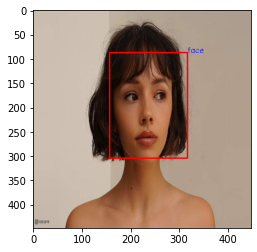

In [150]:
plt.imshow(new_img)

## crop the face portion for the face mask classification

In [89]:
def crop_face(box, img):
  y = [box[1]-1/2*box[3],box[1]+1/2*box[3]]
  x = [box[0]-1/2*box[2],box[0]+1/2*box[2]]
  print(y,x)
  return img[int(y[0]):int(y[1]),int(x[0]):int(x[1])]

[tensor(87.4839, device='cuda:0', grad_fn=<SubBackward0>), tensor(304.7974, device='cuda:0', grad_fn=<AddBackward0>)] [tensor(157.0489, device='cuda:0', grad_fn=<SubBackward0>), tensor(317.9587, device='cuda:0', grad_fn=<AddBackward0>)]


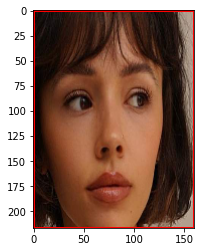

In [151]:
croped_image = crop_face(result, im1)
plt.imshow(croped_image)

convert rectangular image into square

In [153]:
from PIL import Image
croped_image = Image.fromarray(croped_image)

In [92]:
def resize_image(image, length):
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))

        # Amount of pixel to lose in total on the height of the image.
        required_loss = (resized_image.size[1] - length)

        # Crop the height of the image so as to keep the center part.
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))

        # We now have a length*length pixels image.
        return resized_image
    else:
        # This image is in landscape mode or already squared. The width is bigger than the heihgt.

        # This makes the height fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))

        # Amount of pixel to lose in total on the width of the image.
        required_loss = resized_image.size[0] - length

        # Crop the width of the image so as to keep 1080 pixels of the center part.
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))

        # We now have a length*length pixels image.
        return resized_image

In [154]:
resized_image = resize_image(croped_image, 224)

# ALEXNET classifier

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AigV8d7mGnZ9MMZyXOX0")
project = rf.workspace().project("facemask-vzqch")
dataset = project.version(3).download("folder")

     |████████████████████████████████| 145 kB 9.1 MB/s 
     |████████████████████████████████| 178 kB 55.4 MB/s 
     |████████████████████████████████| 1.1 MB 60.2 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 138 kB 93.2 MB/s 
     |████████████████████████████████| 596 kB 72.5 MB/s 
     |████████████████████████████████| 62 kB 996 kB/s 
  Created wheel for roboflow: filename=roboflow-0.1.8-py3-none-any.whl size=20082 sha256=368c2521a4f671b2056b52a908c4bbe272e0c1456b5b220f5511395a96e0ac2f
  Stored in directory: /root/.cache/pip/wheels/db/11/cc/728f5aaa27dd0a16f49c73090f1ef72ba4701c4c0999eba381
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=c4703bcc420a151b93f9bae1a3efd024742a153714647c3aeb1c47322d7bd5ca
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wget
  Attempting uninstall: urllib3
    Found existing inst

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to facemask-3 in folder:: 100%|██████████| 4053/4053 [00:00<00:00, 8775.13it/s]


## data preprocessing

In [27]:
import os
import matplotlib.pyplot as plt
havemask = os.listdir('/content/facemask-3/train/have_mask')
nomask = os.listdir('/content/facemask-3/train/no_mask')
havemask.sort()
nomask.sort()
x_train = []
y_train = []
for file in havemask:
  img_path = os.path.join('/content/facemask-3/train/have_mask',file)
  img = plt.imread(img_path)
  x_train.append(img)
  y_train.append(1)
for file in nomask:
  img_path = os.path.join('/content/facemask-3/train/no_mask',file)
  img = plt.imread(img_path)
  x_train.append(img)
  y_train.append(0)

In [28]:
havemask = os.listdir('/content/facemask-3/valid/have_mask')
nomask = os.listdir('/content/facemask-3/valid/no_mask')
x_val = []
y_val = []
havemask.sort()
nomask.sort()
for file in havemask:
  img_path = os.path.join('/content/facemask-3/valid/have_mask',file)
  img = plt.imread(img_path)
  x_val.append(img)
  y_val.append(1)
for file in nomask:
  img_path = os.path.join('/content/facemask-3/valid/no_mask',file)
  img = plt.imread(img_path)
  x_val.append(img)
  y_val.append(0)

In [29]:
import numpy as np
x_train = np.array(x_train).astype('float32') / 255.
x_val = np.array(x_val).astype('float32') / 255.

convert the label into the one-hot encoding form 

[no_mask, have_mask]

In [30]:
from keras.utils import np_utils
y_val = np_utils.to_categorical(y_val,2)
y_train = np_utils.to_categorical(y_train,2)

shuffle the data

In [70]:
def shuffle(x, y):
  for i in range(x.shape[0]):
    index = np.random.randint(x.shape[0])
    current_x = x[i]
    x[i] = x[index]
    x[index] = current_x
    current_y = y[i]
    y[i] = y[index]
    y[index] = current_y
  return x, y

In [71]:
shuffled_x_train, shuffled_y_train = shuffle(x_train, y_train)
shuffled_x_val, shuffled_y_val = shuffle(x_val, y_val)

[1. 0.]


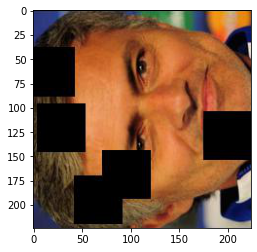

In [75]:
plt.imshow(shuffled_x_train[3887])
print(shuffled_y_train[3887])

## construction of AlexNet model

In [31]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
img_size = 224
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(img_size,img_size,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(img_size,img_size,3)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()
AlexNet.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 256)      1

## training

In [102]:
import tensorflow as tf
history = AlexNet.fit(shuffled_x_train, shuffled_y_train,
                epochs=30,
                batch_size=128,
                shuffle=False,              
                validation_data=(shuffled_x_val, shuffled_y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
31/31 [==============================] - 5s 149ms/step - loss: 0.4484 - accuracy: 0.8703 - val_loss: 3.1607 - val_accuracy: 0.4759
Epoch 2/30
31/31 [==============================] - 4s 145ms/step - loss: 0.3161 - accuracy: 0.9433 - val_loss: 0.3679 - val_accuracy: 0.8621
Epoch 3/30
31/31 [==============================] - 4s 144ms/step - loss: 0.2656 - accuracy: 0.9662 - val_loss: 0.3766 - val_accuracy: 0.8897
Epoch 4/30
31/31 [==============================] - 4s 144ms/step - loss: 0.2389 - accuracy: 0.9782 - val_loss: 0.6959 - val_accuracy: 0.7655
Epoch 5/30
31/31 [==============================] - 4s 145ms/step - loss: 0.2168 - accuracy: 0.9833 - val_loss: 0.4938 - val_accuracy: 0.8690
Epoch 6/30
31/31 [==============================] - 5s 146ms/step - loss: 0.2017 - accuracy: 0.9862 - val_loss: 0.4212 - val_accuracy: 0.8621
Epoch 7/30
31/31 [==============================] - 4s 145ms/step - loss: 0.1907 - accuracy: 0.9872 - val_loss: 0.2549 - val_accuracy: 0.9448
Epoch 

KeyboardInterrupt: ignored

In [103]:
AlexNet.save('AlexNet.h5')

## learning curve

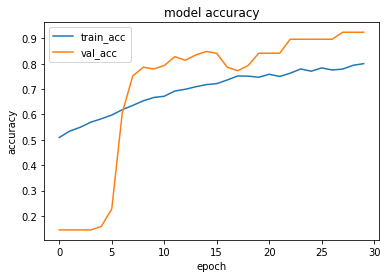

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

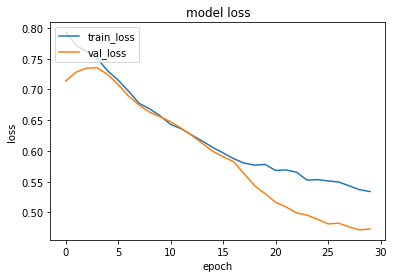

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [33]:
classifier = load_model("/content/saved_models/AlexNet.h5")
scores = classifier.evaluate(x_val, y_val, verbose=0)
print("ACC: %.2f%%" % (scores[1]*100))

ACC: 93.10%


In [95]:
def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index

num2label = {1:'face_mask',0:'no_facemask!'}

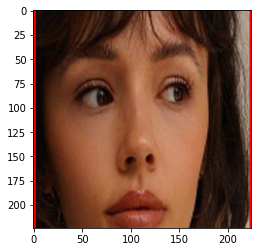

The prediction result is <<<no_facemask!>>>






In [96]:
# making prediction
img = resized_image
pred_img = np.array(img)
plt.figure(figsize=(20, 4))
plt.imshow(img)
plt.show()
#print prediction result
print('The prediction result is <<<{}>>>\n\n\n\n'.format(num2label.get(softmax2label(classifier.predict(pred_img.reshape(1,224,224,3))[0]))))

# the two-stages model

In [267]:
from PIL import Image
import matplotlib.pyplot as plt

def crop_face(box, img):
  y = [box[1]-1/2*box[3],box[1]+1/2*box[3]]
  x = [box[0]-1/2*box[2],box[0]+1/2*box[2]]
  print(y,x)
  return img[int(y[0]):int(y[1]),int(x[0]):int(x[1])]

def resize_image(image, length):
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))

        # Amount of pixel to lose in total on the height of the image.
        required_loss = (resized_image.size[1] - length)

        # Crop the height of the image so as to keep the center part.
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))

        # We now have a length*length pixels image.
        return resized_image
    else:
        # This image is in landscape mode or already squared. The width is bigger than the heihgt.

        # This makes the height fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))

        # Amount of pixel to lose in total on the width of the image.
        required_loss = resized_image.size[0] - length

        # Crop the width of the image so as to keep 1080 pixels of the center part.
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))

        # We now have a length*length pixels image.
        return resized_image

def bounding_box_show(box, image, prediction_label):
  left_top_x = int(box[0]-box[2]/2)
  left_top_y = int(box[1]+box[3]/2)
  right_bottom_x = int(box[0]+box[2]/2)
  right_bottom_y = int(box[1]-box[3]/2)
  left = [left_top_x, right_bottom_y]
  right = [right_bottom_x, left_top_y]
  color = (255, 0, 0) 
  thickness = 2
  img = cv2.rectangle(image, (right[0],right[1]), (left[0],left[1]), color, thickness)
  img = cv2.putText(img,prediction_label,(left[0],left[1]),cv2.FONT_HERSHEY_DUPLEX,1.4,(255,255,255))
  return img

def one_stop(file_path):
  im1 = plt.imread(file_path)
  im1 = cv2.resize(im1, (448,448))
  tensor_im1 =torchvision.transforms.ToTensor()(im1)
  tensor_im1 = tensor_im1.resize(1,tensor_im1.shape[0],tensor_im1.shape[1],tensor_im1.shape[2]).float().cuda()
  result = predict(tensor_im1)
  croped_image = crop_face(result, im1)
  croped_image = Image.fromarray(croped_image)
  resized_image = resize_image(croped_image, 224)
  img = resized_image
  pred_img = np.array(img)
  prediction = num2label.get(softmax2label(classifier.predict(pred_img.reshape(1,224,224,3))[0]))
  final_result = bounding_box_show(result, im1, prediction)
  print("-------------------------------------------------------")
  print("the prediction result is :<<{}>>".format(prediction))
  print("-------------------------------------------------------")
  plt.imshow(final_result)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[tensor(102.5231, device='cuda:0', grad_fn=<SubBackward0>), tensor(241.8310, device='cuda:0', grad_fn=<AddBackward0>)] [tensor(77.5358, device='cuda:0', grad_fn=<SubBackward0>), tensor(192.5301, device='cuda:0', grad_fn=<AddBackward0>)]
-------------------------------------------------------
the prediction result is :<<face_mask>>
-------------------------------------------------------


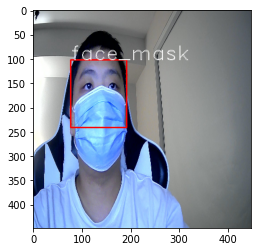

In [268]:
one_stop("/content/WIN_20211124_12_10_22_Pro.jpg")